In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
  col,
  count,
  when,
  to_date,
  regexp_replace,
  year,
  month,
  dayofmonth
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = (SparkSession.builder
         .appName('PySpark App')
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/17 02:04:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Criando DataFrame spark

In [4]:
raw_data = spark.read.csv('/workspaces/car_prices_analytics/data', header=True, inferSchema=True)

## Acessando valores das 5 primeiras linhas

In [5]:
raw_data.show(5)

+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|year| make|              model|      trim| body|transmission|              vin|state|condition|odometer|color|interior|              seller|  mmr|sellingprice|            saledate|
+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg566472|   ca|        5|   16639|white|   black|kia motors americ...|20500|       21500|Tue Dec 16 2014 1...|
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg561319|   ca|        5|    9393|white|   beige|kia motors americ...|20800|       21500|Tue Dec 16 2014 1...|
|2014|  BMW|           3 Series|328i SULEV|Sedan|   automatic|wba3c1c51ek116351|   ca|    

## Tratamento dos dados

### 1. Removendo coluna única para cada linha

In [6]:
df = raw_data.drop('vin')

### 2. Alterar atributo 'saledate' para data no formato padrão e separar em campos de dia, mês e ano

In [7]:
df = df.withColumn("saledate_cleaned", regexp_replace(col("saledate"), " GMT.*", ""))
df = df.withColumn("saledate_final", to_date(regexp_replace(col("saledate_cleaned"), r"(\w{3} )(\w{3} \d{2} \d{4}).*", "$2"), "MMM dd yyyy"))

cols_to_drop = ['saledate', 'saledate_cleaned']
df = df.drop(*cols_to_drop)

df = df.withColumnRenamed('saledate_final', 'saledate')
df = df.withColumn("saledate", col("saledate").cast("string"))

df = df.withColumn("saledate_year", year(df["saledate"]))\
    .withColumn("saletate_month", month(df["saledate"]))\
    .withColumn("saledate_day", dayofmonth(df["saledate"]))

In [8]:
df = df.drop('saledate')

### 3. Analisar valores nulos

### 3.1 Analisar frequencia absoluta

In [9]:
qtd_nulos_por_coluna = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
qtd_nulos_por_coluna.show()

+----+----+-----+----+-----+------------+-----+---------+--------+-----+--------+------+---+------------+-------------+--------------+------------+
|year|make|model|trim| body|transmission|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate_year|saletate_month|saledate_day|
+----+----+-----+----+-----+------------+-----+---------+--------+-----+--------+------+---+------------+-------------+--------------+------------+
|   0|8913| 8998|9243|11787|       56333|    1|    11805|      92|  689|     689|     1| 21|          10|           21|            21|          21|
+----+----+-----+----+-----+------------+-----+---------+--------+-----+--------+------+---+------------+-------------+--------------+------------+



### 3.2 Analisar frequencia relativa

In [10]:
first_row = qtd_nulos_por_coluna.first()
tot_rows = df.count()
for c in qtd_nulos_por_coluna.columns:
  print(f'Perc valores nulos coluna {c.upper()}: {round((first_row[c]/tot_rows) * 100, 3)}%')

Perc valores nulos coluna YEAR: 0.0%
Perc valores nulos coluna MAKE: 1.81%
Perc valores nulos coluna MODEL: 1.828%
Perc valores nulos coluna TRIM: 1.877%
Perc valores nulos coluna BODY: 2.394%
Perc valores nulos coluna TRANSMISSION: 11.442%
Perc valores nulos coluna STATE: 0.0%
Perc valores nulos coluna CONDITION: 2.398%
Perc valores nulos coluna ODOMETER: 0.019%
Perc valores nulos coluna COLOR: 0.14%
Perc valores nulos coluna INTERIOR: 0.14%
Perc valores nulos coluna SELLER: 0.0%
Perc valores nulos coluna MMR: 0.004%
Perc valores nulos coluna SELLINGPRICE: 0.002%
Perc valores nulos coluna SALEDATE_YEAR: 0.004%
Perc valores nulos coluna SALETATE_MONTH: 0.004%
Perc valores nulos coluna SALEDATE_DAY: 0.004%


O atributo 'transmission' possui uma quantidade razoável de valores nulos, e portanto, uma solução apropriada para o preenchimento dos seus dados faltantes seria pela execução do método de machine learning knn. Os demais atributos com valores nulos serão preenchidos pela moda, se for um atributo do tipo categórico, ou pela mediana, se for um atributo do tipo numérico.

In [11]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
category_features = [t[0] for t in df.dtypes if t[1] == 'string']

category_features.remove('transmission') # variavel com mais de 10% será preenchida pelo método knn de ML

In [12]:
for c in category_features:
  mode = df.groupBy(c).count().orderBy('count', ascending=False).first()[c]
  df = df.na.fill({c: mode})

In [13]:
for c in numeric_features:
  median = df.approxQuantile(c, [0.5], 0.01)[0]
  df = df.na.fill({c: median})

### 3.3 Preenchimento pelo método KNN

In [14]:
df_with_transmission_null = df.filter(df.transmission.isNull())
df_with_transmission_not_null = df.filter(df.transmission.isNotNull())

A completar...

### 4. Análise exploratória

### 4.1 Informações estatísticas de atributos numéricos

In [24]:
summary = df_with_transmission_not_null.describe(*numeric_features)
summary.show()

+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|summary|              year|         condition|         odometer|              mmr|      sellingprice|     saledate_year|    saletate_month|      saledate_day|
+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|  count|            436023|            436023|           436023|           436023|            436023|            436023|            436023|            436023|
|   mean|2009.9796753840967| 30.63941810409084|69020.50328537714|13513.99111973451|13352.926524518201|2014.8904644938455|3.4975448542852097|15.784366879728822|
| stddev| 3.976047575958565|13.252325125963814|53542.39157146369|9507.946430115764| 9591.222263712069| 0.312310266793706|3.3352325471828332| 8.773281688059313|
|    min|              1982|            

### 4.2 Análise de matriz de correlação linear entre atributos numéricos

24/06/17 02:29:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/17 02:29:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


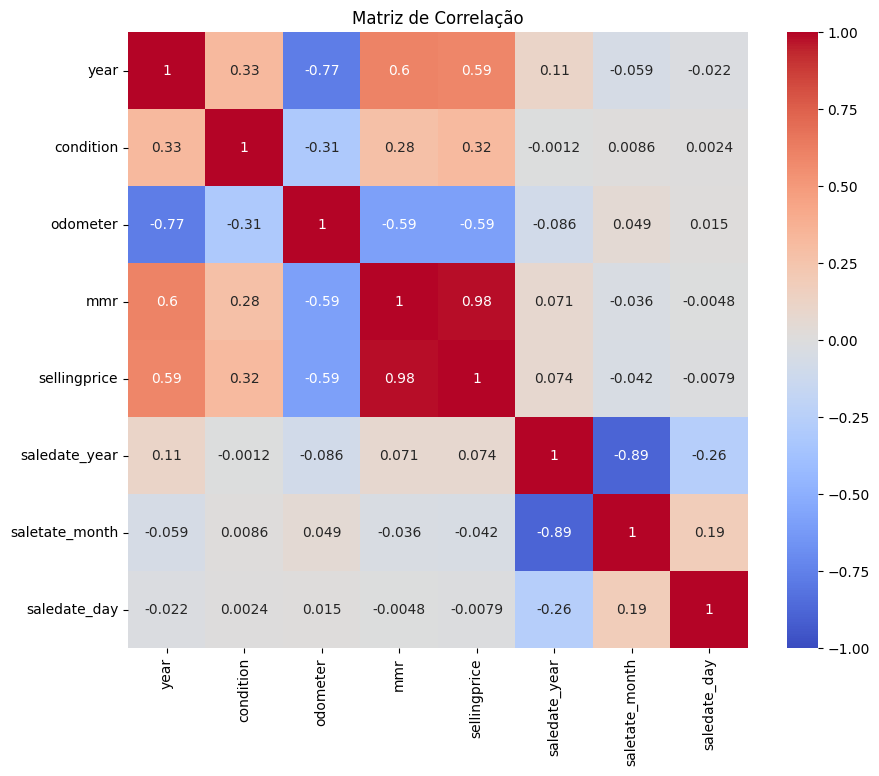

In [25]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")
df_vector = assembler.transform(df_with_transmission_not_null).select("features")

correlation_matrix = Correlation.corr(df_vector, "features").head()[0]
corr_array = correlation_matrix.toArray()

corr_df = pd.DataFrame(corr_array, index=numeric_features, columns=numeric_features)

# Passo 7: Plotar a matriz de correlação usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de Correlação")
plt.show()

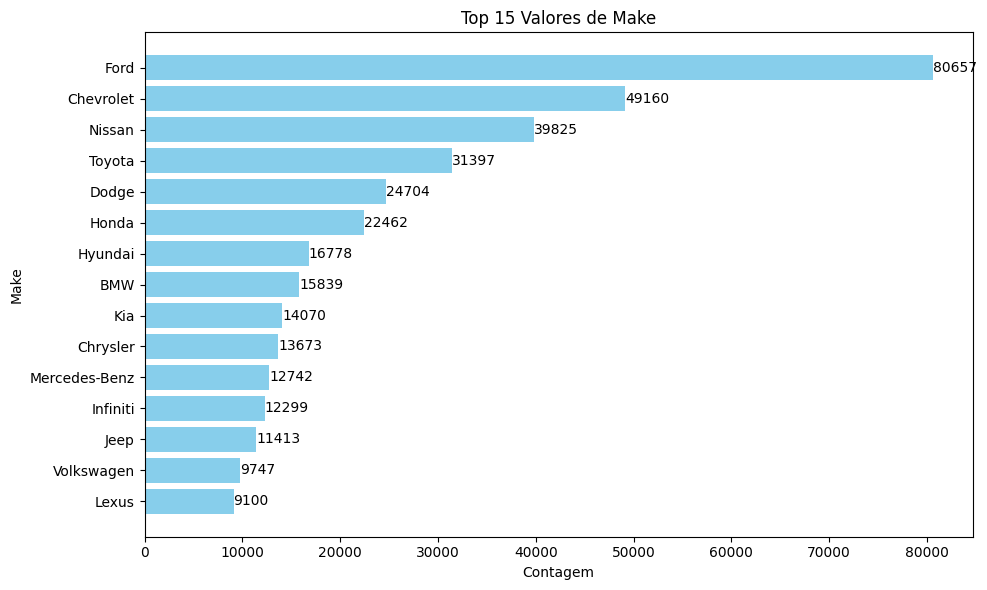

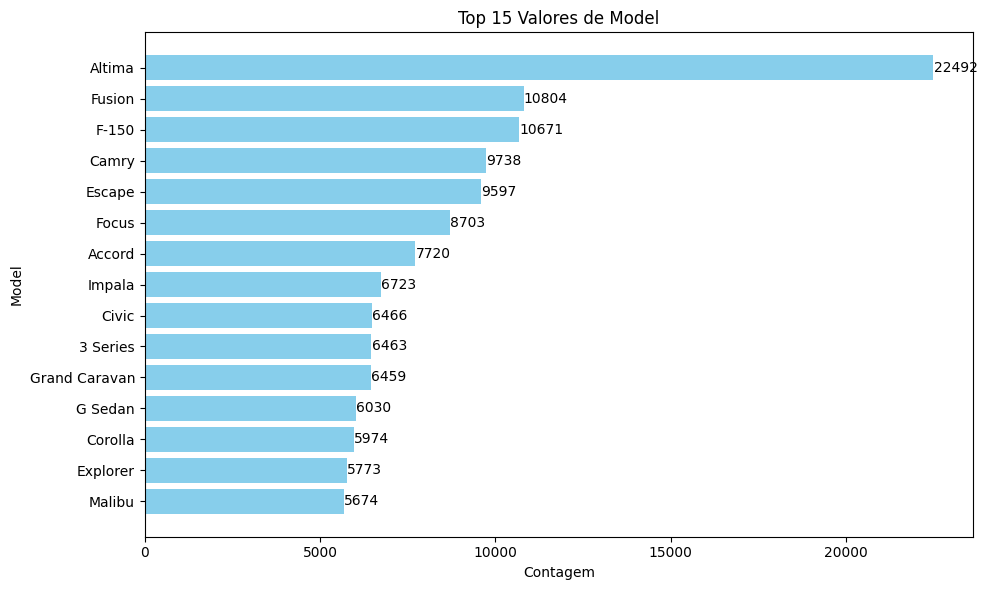

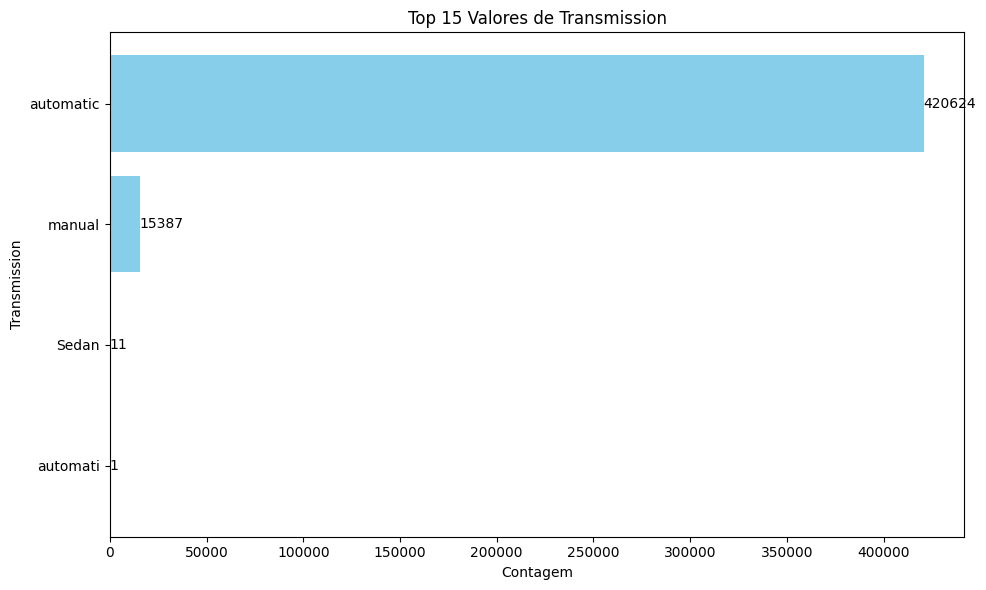

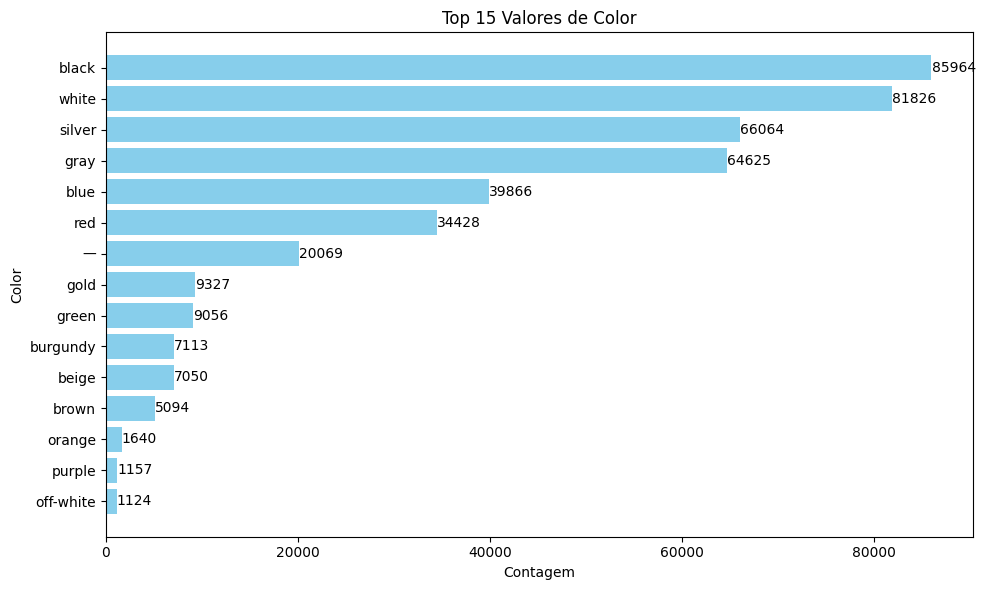

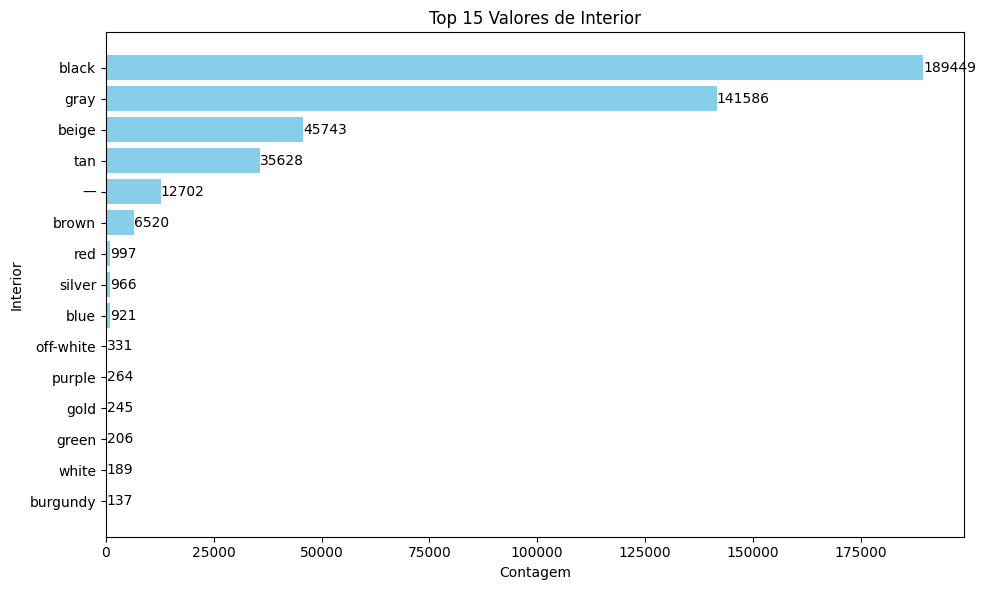

In [26]:
colunas = ['make', 'model', 'transmission', 'color', 'interior']

for coluna in colunas:
  top_valores = df_with_transmission_not_null.groupBy(coluna).count().orderBy('count', ascending=False).limit(15).toPandas()

  plt.figure(figsize=(10, 6))
  bars = plt.barh(top_valores[coluna], top_valores['count'], color='skyblue')

  for bar in bars:
    plt.text(
      bar.get_width() + 5,
      bar.get_y() + bar.get_height() / 2,
      f'{bar.get_width():.0f}',
      ha='left',
      va='center',
      color='black',
      fontsize=10
    )

  plt.xlabel('Contagem')
  plt.ylabel(coluna.capitalize())
  plt.title(f'Top 15 Valores de {coluna.capitalize()}')
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

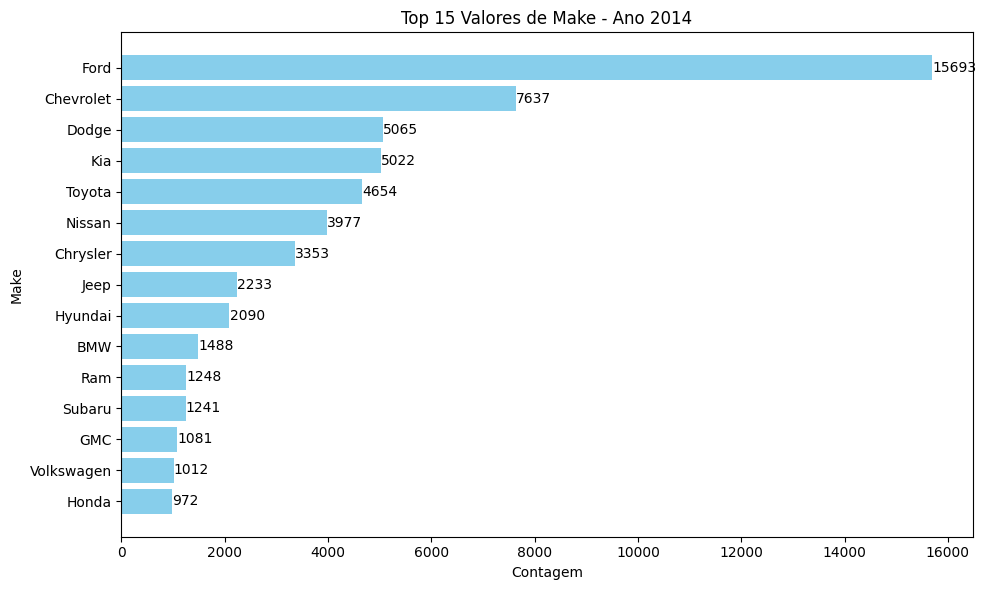

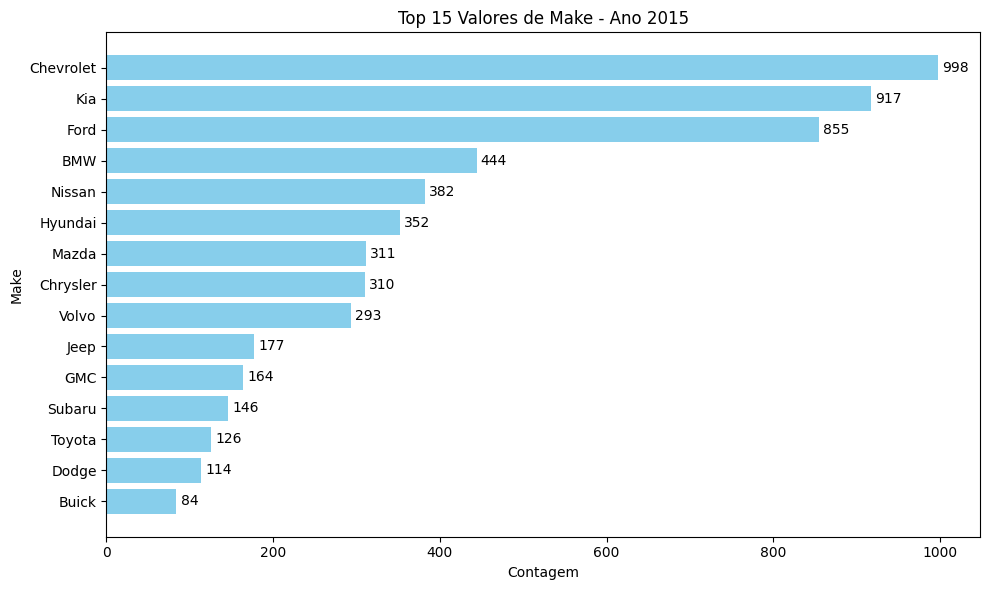

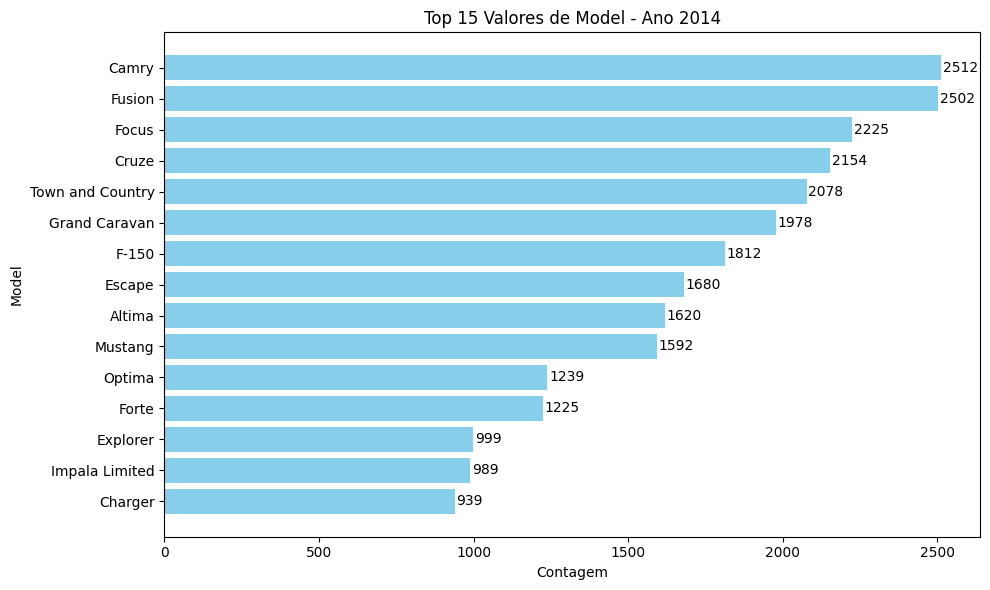

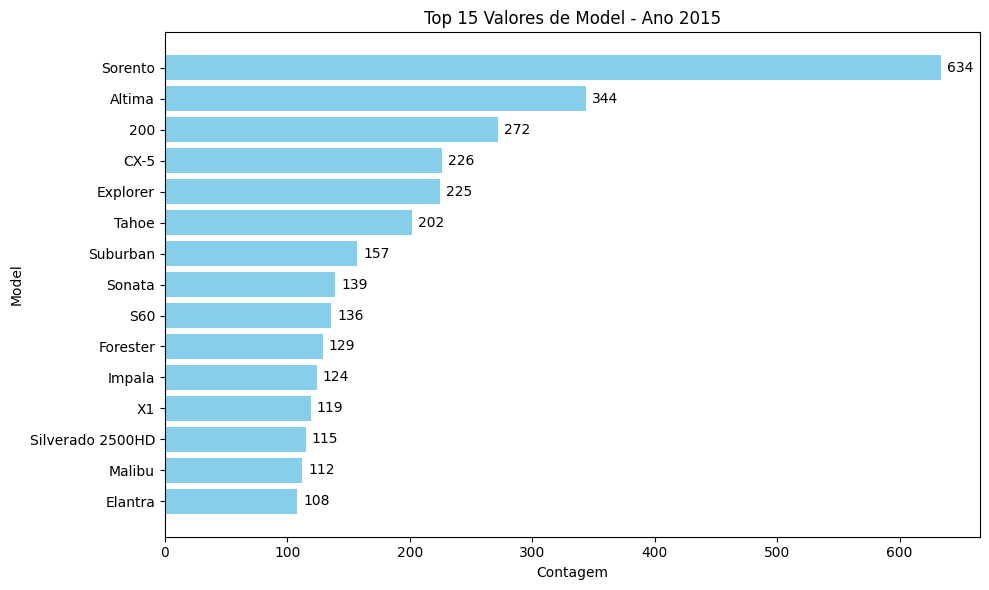

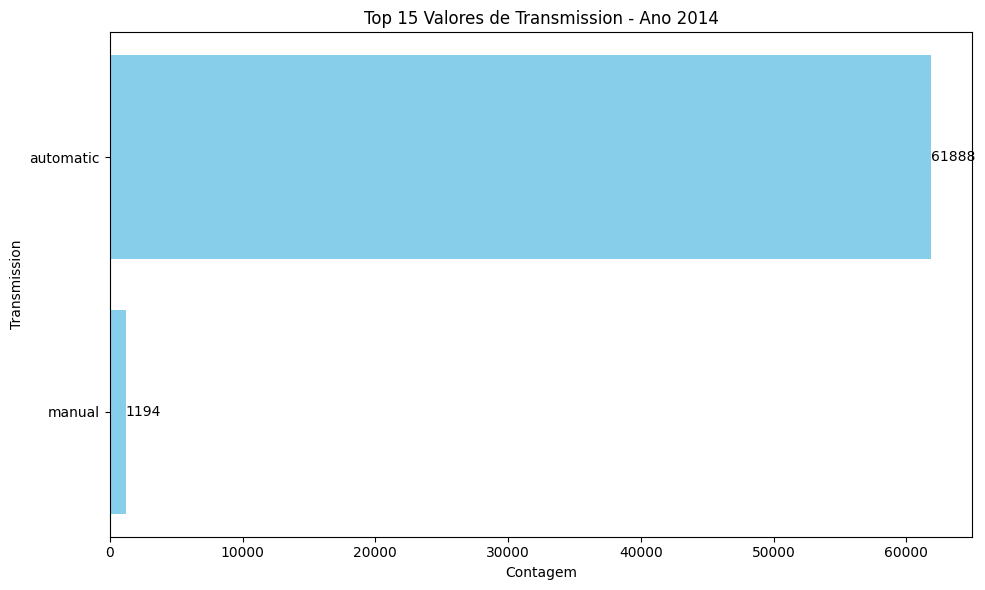

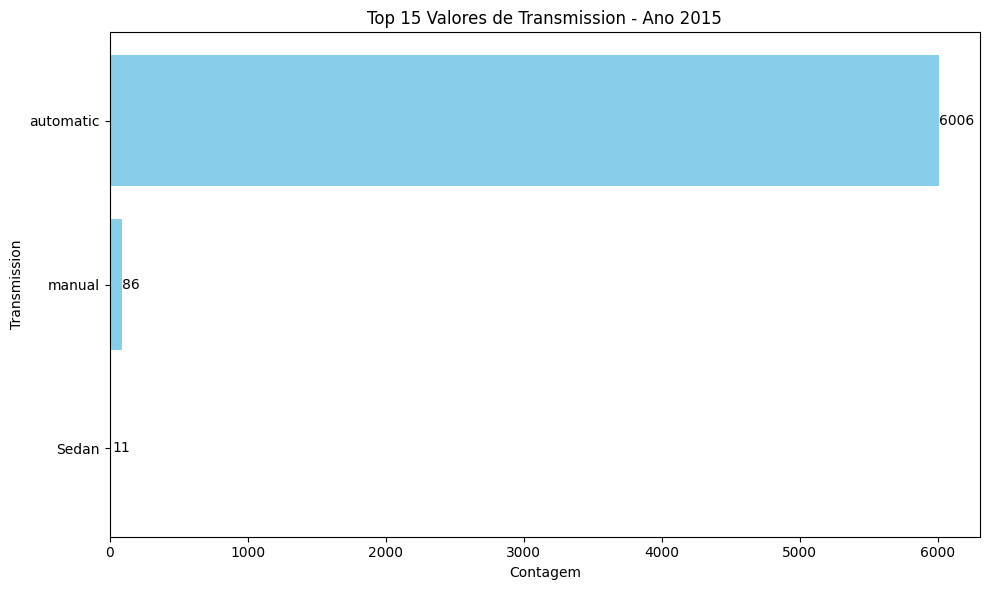

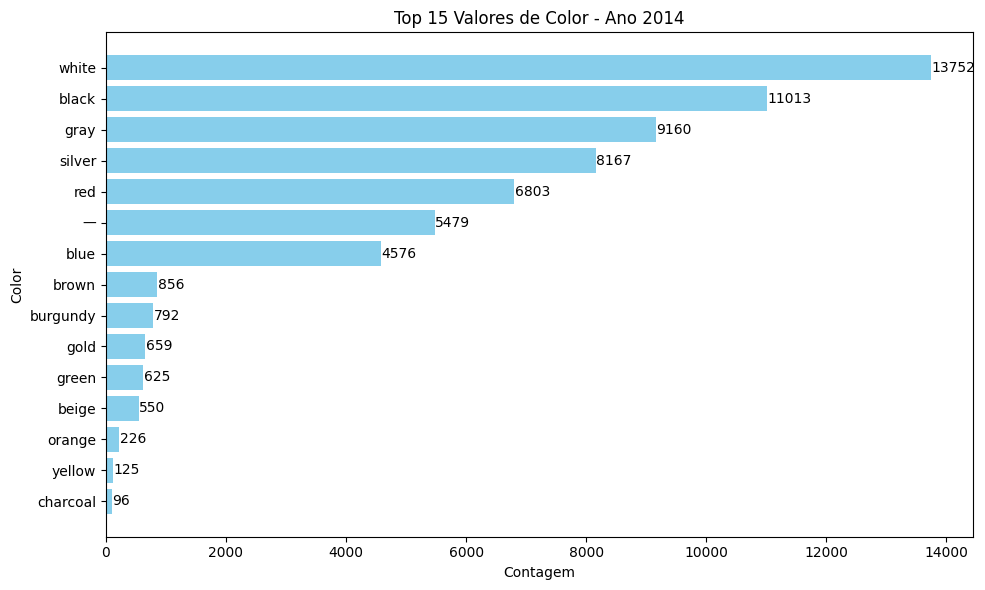

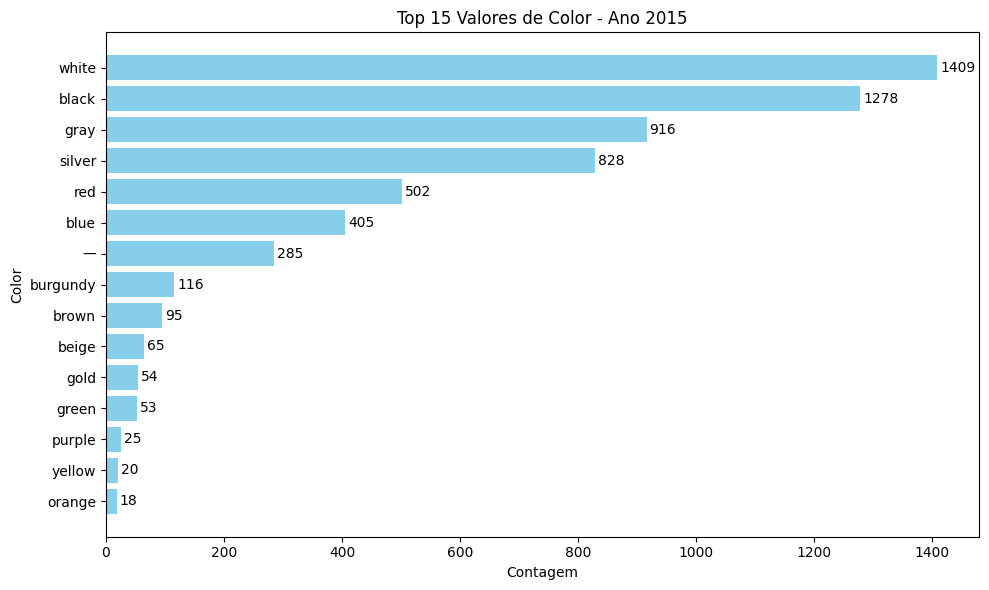

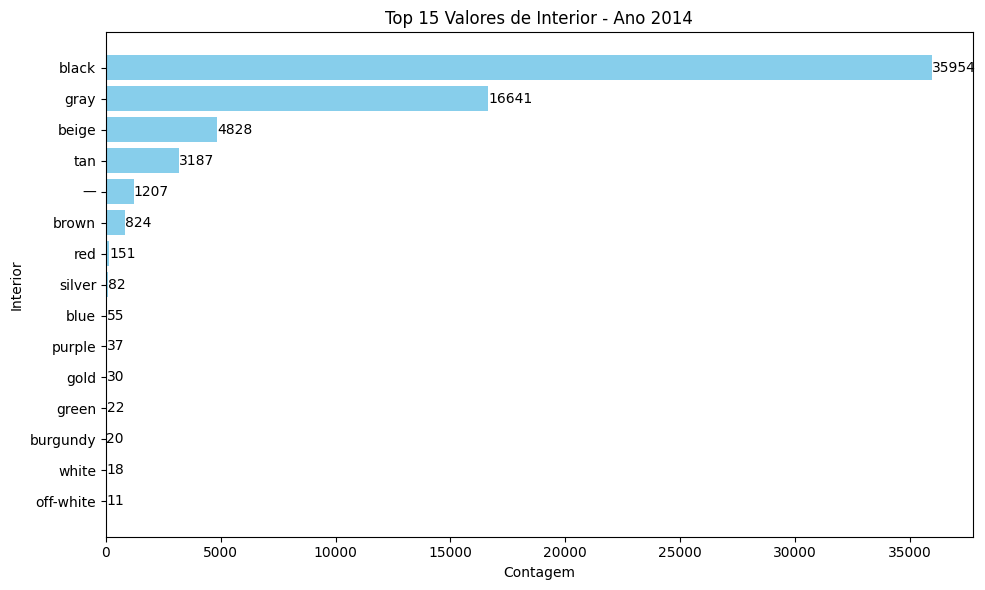

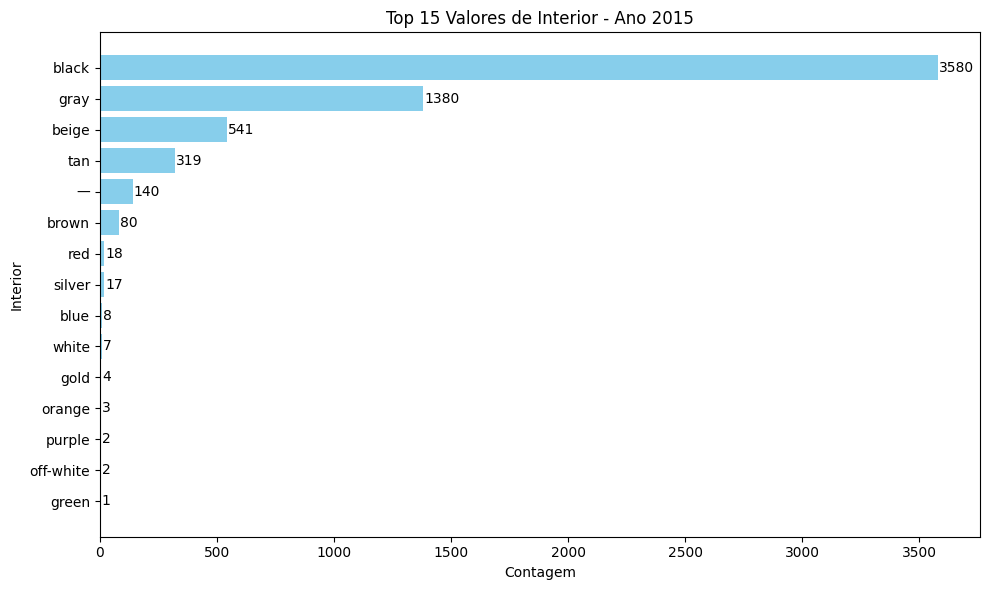

In [28]:
for coluna in colunas:
  for ano in [2014, 2015]:
    df_ano = df_with_transmission_not_null.filter(df_with_transmission_not_null['year'] == ano)
    top_valores = df_ano.groupBy(coluna).count().orderBy('count', ascending=False).limit(15).toPandas()

    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_valores[coluna], top_valores['count'], color='skyblue')

    for bar in bars:
      plt.text(
        bar.get_width() + 5,
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.0f}',
        ha='left',
        va='center',
        color='black',
        fontsize=10
      )

    plt.xlabel('Contagem')
    plt.ylabel(coluna.capitalize())
    plt.title(f'Top 15 Valores de {coluna.capitalize()} - Ano {ano}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()